In [1]:
#Handle Imports
import cv2
import numpy as np
import math
import os
import pylab as pl
import matplotlib.pyplot as plt
import random

from keras.models import model_from_json

from __future__ import print_function
from __future__ import division
np.random.seed(1337)  # for reproducibility

%matplotlib inline

Using TensorFlow backend.


In [2]:
windowsize = 32
batch_size = 128
epochs = 5
target_size = (32, 32)
model_path = 'models/'
model_name = 'model'
full_image_path = 'data/validation/full_images/'
detection_image_path = 'data/validation/full_images_detected'
detected_particles_path = "data/validation/detected_particles"
segmented_particles_path = "data/validation/segmented_particles"

In [ ]:
pyramid = [(.5, 3), (1, 3), (1.25, 3), (1.5, 3), (1.7, 3)]

In [ ]:
# load json and create model
json_file = open(os.path.join(model_path, model_name + ".json"), 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights(os.path.join(model_path, model_name + ".h5"))
print("Loaded model from disk")

Loaded model from disk


In [ ]:
if not os.path.isdir(detected_particles_path):
    os.makedirs(detected_particles_path)

detections = []

for f_name in os.listdir(full_image_path):
    original = cv2.imread(os.path.join(full_image_path, f_name), 0) / 255
    
    for scale, stride in pyramid:
    
        img = cv2.resize(original, (int(original.shape[1] * scale), int(original.shape[0] * scale)))

        if not os.path.isdir(detected_particles_path):
            os.makedirs(detected_particles_path)

        height = windowsize
        width = windowsize

        coords = []

        for x in xrange(0, img.shape[1] - width, stride):
            for y in xrange(0, img.shape[0] - height, stride):
                coords.append([x, y, x + width, y + height])

        coords = np.stack(coords)

        imgs = []

        for coord in coords:
            x_start = coord[0]
            y_start = coord[1]
            x_end = coord[2]
            y_end = coord[3]
            imgs.append(img[y_start:y_end, x_start:x_end, ...])

        imgs = np.stack(imgs)

        imgs = np.expand_dims(imgs, -1)

        preds = model.predict(imgs, verbose=1)
        p_coords = coords[np.isin(preds[:, 1], 1)]

        pick = non_max_suppression_fast(p_coords, 0.4)
        post_suppress = np.copy(original)
        for coord in pick:
            x_start = coord[0]
            y_start = coord[1]
            x_end = coord[2]
            y_end = coord[3]
             
            detections.append((coord, img[y_start:y_end, x_start:x_end, ...] * 255))
            
#             cv2.imwrite(os.path.join(detected_particles_path, '{}_{}_{}_{}_{}.jpg'.format(f_name, x_start, y_start, x_end, y_end)), img[y_start:y_end, x_start:x_end, ...] * 255)
#             cv2.rectangle(post_suppress, (int(x_start // scale), int(y_start // scale)), (int(x_end // scale), int(y_end // scale)), (0, 255, 0), 2)

    if not os.path.exists(detection_image_path):
        os.mkdir(detection_image_path)
        
    cv2.imwrite(os.path.join(detection_image_path, f_name), post_suppress * 255)

In [20]:
## Imports

In [22]:
import os
print(os.environ['PATH'])  # make sure the path is in the Particle-Detector directory

from scipy import ndimage as ndi

import matplotlib.pyplot as plt
from matplotlib.spines import Spine
from matplotlib.path import Path

from skimage.morphology import watershed, disk
from skimage.filters import rank
from skimage.util import img_as_ubyte

import numpy as np

import cv2



/home/collin/anaconda2/bin:/home/collin/anaconda2/bin:~/bin:~/anaconda/bin:~/anaconda/bin:/home/collin/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/home/collin/anaconda2/lib/python2.7/site-packages/cv2


### Outline the particles

In [23]:
Base_address = ""# "/home/seyed/Documents/COMP 496ML/"

### getting the right folders

### Read images to be processed from the Observed file

In [24]:
particles = []
names = []

#load Positives
for f_name in os.listdir(detected_particles_path):
    particle = cv2.imread(os.path.join(detected_particles_path, f_name), 0)
    particles.append(particle)
    names.append(f_name)
    
particles = np.stack(particles)

### Modify files in Observed to a Threshhold using the Otsu algorithm

In [25]:
gradient_data = []
np.set_printoptions(threshold=5)

for d in particles:
    
    img = np.array(d)
    #blur = cv2.bilateralFilter(img,9,75,75)
    blur = cv2.GaussianBlur(img,(5,5),0)
    #blur = cv2.blur(img, (5,5))
    ret, thres = cv2.threshold(blur,0,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    print(thres)
    
    gradient_data.append(thres)

[[255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]
 ..., 
 [255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]]
[[255 255   0 ...,   0   0   0]
 [255 255   0 ...,   0   0   0]
 [255 255   0 ...,   0   0   0]
 ..., 
 [255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]]
[[255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]
 ..., 
 [255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]]
[[  0   0   0 ..., 255 255 255]
 [  0   0   0 ..., 255 255 255]
 [  0   0   0 ..., 255 255 255]
 ..., 
 [255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]]
[[255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]
 ..., 
 [255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]]


### Chanvese processing

In [26]:
def showim(imgpassed):
    
    cv2.imshow('image', imgpassed)
    k = cv2.waitKey(0)
    if k == 27:         # wait for ESC key to exit
        cv2.destroyAllWindows()
    elif k == ord('s'): # wait for 's' key to save and exit
        cv2.imwrite('particle',img)
        cv2.destroyAllWindows()
    

iteration: 0
iteration: 50
iteration: 100
iteration: 150


/home/collin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:267: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.


iteration: 200
iteration: 250
iteration: 300
iteration: 350
iteration: 400
iteration: 450
iteration: 500
iteration: 550
iteration: 600
iteration: 650
iteration: 700
iteration: 750
iteration: 800
iteration: 850
iteration: 900
iteration: 950
saving file
iteration: 0
iteration: 50
iteration: 100
iteration: 150
iteration: 200
iteration: 250
iteration: 300
iteration: 350
iteration: 400
iteration: 450
iteration: 500
iteration: 550
iteration: 600
iteration: 650
iteration: 700
iteration: 750
iteration: 800
iteration: 850
iteration: 900
iteration: 950
saving file
iteration: 0
iteration: 50
iteration: 100
iteration: 150
iteration: 200
iteration: 250
iteration: 300
iteration: 350
iteration: 400
iteration: 450
iteration: 500
iteration: 550
iteration: 600
iteration: 650
iteration: 700
iteration: 750
iteration: 800
iteration: 850
iteration: 900
iteration: 950
saving file
iteration: 0
iteration: 50
iteration: 100
iteration: 150
iteration: 200
iteration: 250
iteration: 300
iteration: 350
iteration: 40

/home/collin/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


iteration: 50
iteration: 100
iteration: 150
iteration: 200
iteration: 250
iteration: 300
iteration: 350
iteration: 400
iteration: 450
iteration: 500
iteration: 550
iteration: 600
iteration: 650
iteration: 700
iteration: 750
iteration: 800
iteration: 850
iteration: 900
iteration: 950
saving file
iteration: 0
iteration: 50
iteration: 100
iteration: 150
iteration: 200
iteration: 250
iteration: 300
iteration: 350
iteration: 400
iteration: 450
iteration: 500
iteration: 550
iteration: 600
iteration: 650
iteration: 700
iteration: 750
iteration: 800
iteration: 850
iteration: 900
iteration: 950
saving file
iteration: 0
iteration: 50
iteration: 100
iteration: 150
iteration: 200
iteration: 250
iteration: 300
iteration: 350
iteration: 400
iteration: 450
iteration: 500
iteration: 550
iteration: 600
iteration: 650
iteration: 700
iteration: 750
iteration: 800
iteration: 850
iteration: 900
iteration: 950
saving file
iteration: 0
iteration: 50
iteration: 100
iteration: 150
iteration: 200
iteration: 250

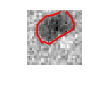

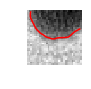

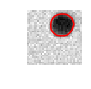

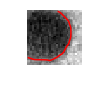

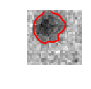

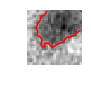

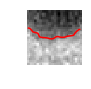

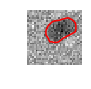

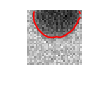

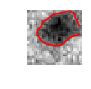

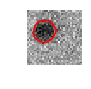

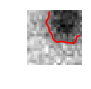

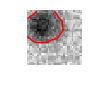

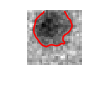

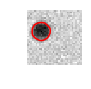

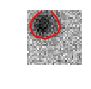

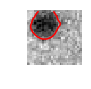

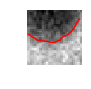

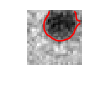

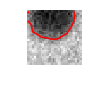

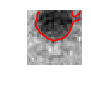

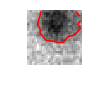

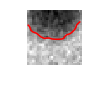

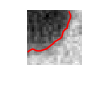

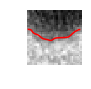

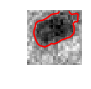

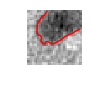

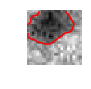

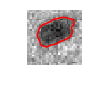

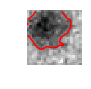

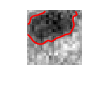

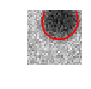

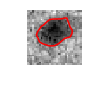

In [27]:
import numpy as np
import scipy.ndimage as nd
import matplotlib.pyplot as plt

count = 0
circled_data = []
eps = np.finfo(float).eps
max_its = 1000
figure_size = 32

phi_set = []


def chanvese(I, original_I, init_mask, max_its=200, alpha=0.2,
             thresh=0, color='r', display=False):
    I = I.astype(np.float)

    # Create a signed distance map (SDF) from mask
    phi = mask2phi(init_mask)

    if display:
        plt.ion()
        fig = plt.figure(figsize=(1,1))
        ax = fig.add_subplot(111)
        ax.seton=False
        
        #fig, axes = plt.subplots(ncols=1)
        show_curve_and_phi(fig, I, original_I, phi, color)
        plt.savefig('levelset_start.png', bbox_inches='tight')

    # Main loop
    its = 0
    stop = False
    prev_mask = init_mask
    c = 0

    while (its < max_its and not stop):
        # Get the curve's narrow band
        idx = np.flatnonzero(np.logical_and(phi <= 1.2, phi >= -1.2))

        if len(idx) > 0:
            # Intermediate output
            if display:
                if np.mod(its, 50) == 0:
                    print('iteration: {0}'.format(its))
                    show_curve_and_phi(fig, I, original_I, phi, color)
            else:
                if np.mod(its, 10) == 0:
                    print('iteration: {0}'.format(its))

            # Find interior and exterior mean
            upts = np.flatnonzero(phi <= 0)  # interior points
            vpts = np.flatnonzero(phi > 0)  # exterior points
            u = np.sum(I.flat[upts]) / (len(upts) + eps)  # interior mean
            v = np.sum(I.flat[vpts]) / (len(vpts) + eps)  # exterior mean

            # Force from image information
            F = (I.flat[idx] - u)**2 - (I.flat[idx] - v)**2
            # Force from curvature penalty
            curvature = get_curvature(phi, idx)

            # Gradient descent to minimize energy
            dphidt = F / np.max(np.abs(F)) + alpha * curvature

            # Maintain the CFL condition
            dt = 0.45 / (np.max(np.abs(dphidt)) + eps)

            # Evolve the curve
            phi.flat[idx] += dt * dphidt

            # Keep SDF smooth
            phi = sussman(phi, 0.5)

            new_mask = phi <= 0
            c = convergence(prev_mask, new_mask, thresh, c)

            if c <= 5:
                its = its + 1
                prev_mask = new_mask
            else:
                stop = True

        else:
            break

    # Final output
    if display:
        
        print('saving file')
        ####### saving to file 'segmented particle' with the 
        global count 
        Observed_name = names[count]
        
        if not os.path.exists(segmented_particles_path):
            os.mkdir(segmented_particles_path)
        
        Segmented_path = os.path.join(segmented_particles_path, Observed_name)
        x_start = Observed_name[0]
        y_start = Observed_name[1]
        filename = Segmented_path + '{}_{}.jpg'.format(x_start, y_start)
        count = count + 1
        
        plt.savefig(filename, bbox_inches='tight',pad_inches = 0, dpi=64)
            
        show_curve_and_phi(fig, I, original_I, phi, color)
        
        
        
        #plt.savefig('levelset_end.png', bbox_inches='tight')

    # Make mask from SDF
    seg = phi <= 0  # Get mask from levelset

    return seg, phi, its


# ---------------------------------------------------------------------
# ---------------------- AUXILIARY FUNCTIONS --------------------------
# ---------------------------------------------------------------------

def bwdist(a):
    """
    Intermediary function. 'a' has only True/False vals,
    so we convert them into 0/1 values - in reverse.
    True is 0, False is 1, distance_transform_edt wants it that way.
    """
    return nd.distance_transform_edt(a == 0)


# Displays the image with curve superimposed
def show_curve_and_phi(fig, I, original_I, phi, color):
    
    #fig.tight_layout(pad=0)
    

    for spine in plt.gca().spines.values():
        spine.set_visible(False)
        
    fig.axes[0].cla()
    fig.axes[0].set_axis_off()
    fig.axes[0].imshow(original_I, cmap='gray')
    fig.axes[0].contour(phi, 0, colors=color)
    
    plt.draw()
    
    
    # Now we can save it to a numpy array.
    #data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    #data = data.reshape((fig.canvas.get_width_height()[::-1] + (3,)))
    
    #circled_data.append(data)
    
    
    
    plt.pause(0.001)


def im2double(a):
    a = a.astype(np.float)
    a /= np.abs(a).max()
    return a


# Converts a mask to a SDF
def mask2phi(init_a):
    phi = bwdist(init_a) - bwdist(1 - init_a) + im2double(init_a) - 0.5
    return phi


# Compute curvature along SDF
def get_curvature(phi, idx):
    dimy, dimx = phi.shape
    yx = np.array([np.unravel_index(i, phi.shape) for i in idx])  # subscripts
    y = yx[:, 0]
    x = yx[:, 1]

    # Get subscripts of neighbors
    ym1 = y - 1
    xm1 = x - 1
    yp1 = y + 1
    xp1 = x + 1

    # Bounds checking
    ym1[ym1 < 0] = 0
    xm1[xm1 < 0] = 0
    yp1[yp1 >= dimy] = dimy - 1
    xp1[xp1 >= dimx] = dimx - 1

    # Get indexes for 8 neighbors
    idup = np.ravel_multi_index((yp1, x), phi.shape)
    iddn = np.ravel_multi_index((ym1, x), phi.shape)
    idlt = np.ravel_multi_index((y, xm1), phi.shape)
    idrt = np.ravel_multi_index((y, xp1), phi.shape)
    idul = np.ravel_multi_index((yp1, xm1), phi.shape)
    idur = np.ravel_multi_index((yp1, xp1), phi.shape)
    iddl = np.ravel_multi_index((ym1, xm1), phi.shape)
    iddr = np.ravel_multi_index((ym1, xp1), phi.shape)

    # Get central derivatives of SDF at x,y
    phi_x = -phi.flat[idlt] + phi.flat[idrt]
    phi_y = -phi.flat[iddn] + phi.flat[idup]
    phi_xx = phi.flat[idlt] - 2 * phi.flat[idx] + phi.flat[idrt]
    phi_yy = phi.flat[iddn] - 2 * phi.flat[idx] + phi.flat[idup]
    phi_xy = 0.25 * (- phi.flat[iddl] - phi.flat[idur] +
                     phi.flat[iddr] + phi.flat[idul])
    phi_x2 = phi_x**2
    phi_y2 = phi_y**2

    # Compute curvature (Kappa)
    curvature = ((phi_x2 * phi_yy + phi_y2 * phi_xx - 2 * phi_x * phi_y * phi_xy) /
                 (phi_x2 + phi_y2 + eps) ** 1.5) * (phi_x2 + phi_y2) ** 0.5

    return curvature


# Level set re-initialization by the sussman method
def sussman(D, dt):
    # forward/backward differences
    a = D - np.roll(D, 1, axis=1)
    b = np.roll(D, -1, axis=1) - D
    c = D - np.roll(D, -1, axis=0)
    d = np.roll(D, 1, axis=0) - D

    a_p = np.clip(a, 0, np.inf)
    a_n = np.clip(a, -np.inf, 0)
    b_p = np.clip(b, 0, np.inf)
    b_n = np.clip(b, -np.inf, 0)
    c_p = np.clip(c, 0, np.inf)
    c_n = np.clip(c, -np.inf, 0)
    d_p = np.clip(d, 0, np.inf)
    d_n = np.clip(d, -np.inf, 0)

    a_p[a < 0] = 0
    a_n[a > 0] = 0
    b_p[b < 0] = 0
    b_n[b > 0] = 0
    c_p[c < 0] = 0
    c_n[c > 0] = 0
    d_p[d < 0] = 0
    d_n[d > 0] = 0

    dD = np.zeros_like(D)
    D_neg_ind = np.flatnonzero(D < 0)
    D_pos_ind = np.flatnonzero(D > 0)

    dD.flat[D_pos_ind] = np.sqrt(
        np.max(np.concatenate(
            ([a_p.flat[D_pos_ind]**2], [b_n.flat[D_pos_ind]**2])), axis=0) +
        np.max(np.concatenate(
            ([c_p.flat[D_pos_ind]**2], [d_n.flat[D_pos_ind]**2])), axis=0)) - 1
    dD.flat[D_neg_ind] = np.sqrt(
        np.max(np.concatenate(
            ([a_n.flat[D_neg_ind]**2], [b_p.flat[D_neg_ind]**2])), axis=0) +
        np.max(np.concatenate(
            ([c_n.flat[D_neg_ind]**2], [d_p.flat[D_neg_ind]**2])), axis=0)) - 1

    D = D - dt * sussman_sign(D) * dD
    return D


def sussman_sign(D):
    return D / np.sqrt(D**2 + 1)


# Convergence Test
def convergence(p_mask, n_mask, thresh, c):
    diff = p_mask - n_mask
    n_diff = np.sum(np.abs(diff))
    if n_diff < thresh:
        c = c + 1
    else:
        c = 0
    return c


if __name__ == "__main__":
    #img = nd.imread('gradient_1.jpg', flatten=True)
    
    for original_image, gradient_image in zip(particles, gradient_data):
        
        mask = np.zeros(gradient_image.shape)
        mask[20:100, 20:100] = 1
        

        chanvese(gradient_image, original_image, mask, max_its=1000, display=True, alpha=1.0)

### Read images from the Post_Processing folder

In [66]:
segmented_data = []

for Segment in os.listdir(segmented_particles_path):
    particle = cv2.imread(os.path.join(segmented_particles_path, Segment))
    segmented_data.append(particle)

### Cut the white bounding boxes from mathplotlibs output

In [67]:
counttop = 3
countright = 3
countleft = 17
countbottom = 15

toresize = []

for segmented in segmented_data:
    
    
    arr = segmented
    
    for i in range(counttop):
        arr = np.delete(arr, (0), axis=0 )    
        
    for i in range(countright):
        arr = np.delete(arr, (arr.shape[1]-1), axis=1 )
    
    for i in range(countleft):
        arr = np.delete(arr, (0), axis=1 )
        
    for i in range(countbottom):
        arr = np.arr = np.delete(arr, (arr.shape[0]-1), axis=0 )

    
    toresize.append(arr)


### Resize file to 32, 32

In [68]:
segmented = []

for resize in toresize:
    im = resize
    resize = cv2.resize(im, (32,32))
    segmented.append(resize)

In [51]:
display(HTML('<h1>Save file to "Segmented_Particle"</h1>'))

In [52]:
countin = 0

for i in range(len(segmented)):
    Segmented_particle = Base_address + 'Segmented_Particle/'
    x_start = name_set[i][0]
    y_start = name_set[i][1]
    
    output_file_name = '{}_{}.jpg'.format(x_start, y_start)
    output_full_path = Segmented_particle + output_file_name
    
    cv2.imwrite(output_full_path, segmented[i])

In [53]:
display(HTML('<h1>Contour extraction"</h1>'))

In [55]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [56]:
display(HTML('<h1>Helper functions"</h1>'))

In [57]:
def showim(imgpassed):
    
    cv2.imshow('image', imgpassed)
    k = cv2.waitKey(0)
    if k == 27:         # wait for ESC key to exit
        cv2.destroyAllWindows()
    elif k == ord('s'): # wait for 's' key to save and exit
        cv2.imwrite('particle',img)
        cv2.destroyAllWindows()
    

In [58]:
display(HTML('<h1>checking the proper directories"</h1>'))

In [59]:
Base_address = ""
Segmented_Particle_path = "Segmented_Particle/"
Segmented_Particle_Rectangle_path = "Segmented_Particle_Rectangle/"

In [60]:
Segmented_Particle_Rectangle_dir = os.path.dirname(Base_address + Segmented_Particle_Rectangle_path)

if not os.path.exists(Segmented_Particle_Rectangle_dir):
    os.makedirs(Segmented_Particle_Rectangle_dir)
    print("Making Segmented_Particle_Rectangle file.")
    

In [61]:
display(HTML('<h1>Loading from directory</h1>'))

In [62]:
direc = Base_address + Segmented_Particle_path

Segmented = [f for f in os.listdir(direc) if os.path.isfile(os.path.join(direc, f))]

data = []
name_set = []

#load Positives
for Segment in Segmented:
    path = direc + Segment
    
    particle = cv2.imread(path, 1)
    
    
    file_name = Segment
    replace = file_name.replace('.','_')
    array_offsets = replace.split('_')
    
    x_offset = int(array_offsets[0])
    y_offset = int(array_offsets[1])
    
    name_set.append([x_offset, y_offset])
    data.append(particle)
    

In [63]:
display(HTML('<h1>Mask boundaries"</h1>'))

In [64]:
lower = np.array([0, 15, 100])
upper = np.array([255, 80, 255])

In [65]:
display(HTML('<h1>Calculating the size distribution for the segmented particles</h1>'))

In [66]:
size_dist = []
images = []

for d in data:

    image = d

    mask = cv2.inRange(image, lower, upper)
    output = cv2.bitwise_and(image, image, mask=mask)
    width, height = output.shape[:2]

    img = cv2.cvtColor(output, cv2.COLOR_BGR2GRAY)

    blur = cv2.GaussianBlur(img,(5,5),0)
    ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    im2, contours, hierarchy = cv2.findContours(th3, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)


    largest_area = 0

    for contour in contours:

        cnt = contour
        x,y,w,h = cv2.boundingRect(cnt)
        area = w*h

        if (area > largest_area):

            largest_area = area
            index_of_largest_area = contour
            largest_cnt = cnt

        #cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)

    rect = cv2.minAreaRect(largest_cnt)
    box = cv2.boxPoints(rect)
    p1, p2, p3, p4 = np.int0(box)
    
    # start shoelace calculation
    area = ((p1[0]*p2[1] - p2[0]*p1[1]) + (p2[0]*p3[1] - p3[0]*p2[1]) + (p3[0]*p4[1] - p4[0]*p3[1]) + (p4[0]*p1[1] - p1[0]*p4[1]))/2
    box = np.int0(box)

    cv2.drawContours(image,[box],0,(0,255,0),1)
    #showim(image)
    
    images.append(image)

    size_dist.append(area)

In [67]:
display(HTML('<h1>Generating the distribution Dataframe & plots</h1>'))

In [68]:
df = pd.DataFrame(size_dist, columns=['Area'])

In [69]:
df.iplot(kind='hist', xTitle='Size of Particle', yTitle='Frequency of Size')

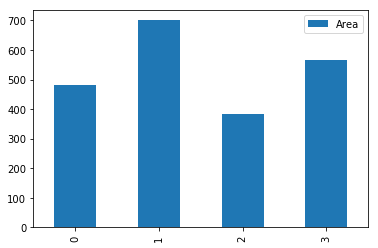

In [70]:
df.plot.bar()

In [71]:
df.iplot(kind='hist', xTitle='Size of Particle', yTitle='Frequency of Size')

In [72]:
display(HTML('<h1>Saving files to "Segmented_Particle_rectangle" folder</h1>'))

In [73]:
for i in range(len(size_dist)):
    Segmented_particle = Base_address + 'Segmented_Particle_Rectangle/'
    x_start = name_set[i][0]
    y_start = name_set[i][1]
    
    output_file_name = '{}_{}_size.jpg'.format(x_start, y_start)
    output_full_path = Segmented_particle + output_file_name
    
    cv2.imwrite(output_full_path, images[i])